This program analyses the breast cancer tumor dataset to find the gene products which are statistically different between relapse and non relapsing breast cancer

At the end it applies machine learning to build a model which can be used to predict whether or not a cancer tumor will relapse based on the clustered expression levels of the gene products from step 1

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [13]:
def sanitizeDistantRelapseEvent(rawData):
    noWords = rawData.replace('distant-relapse event: ','')
    ret = int(noWords)
    if ret != 0 and ret != 1:
        print('Invalid value for distant-relapse event: ' + rawData)
    return ret

def sanitizeDistantRelapseFreeSurvival(rawData):
    noWords = rawData.replace('distant-relapse free survival: ','')
    return float(noWords)

In [37]:
def findAllTumorIdsWithRelapseEvent(value, tumorIdToRelpaseEvent):
    ret = [];
    for k,v in tumorIdToRelpaseEvent.items():
        if v == value:
            ret.append(k)
    return ret

In [4]:
def constructPdfData(data, bins, cumulate):
    ret = [];
    numBins = len(bins)
    binsRange = range(0,numBins)
    count = len(data) #total number of tumors with this gene
    #initalize the returned data with 0 counts in all bins
    for i in binsRange:
        ret.append(0)
    
    #go through the expressionData and bin it
    for v in data:
        for i in binsRange:
            if i == 0:
                if v < bins[i+1]: #anything lower then the second bin value is in the first bin
                    ret[i] += 1
            elif i == numBins - 1: #anything equal to or higher then the last bin value is in the last bin
                if v >= bins[i]: 
                    ret[i] += 1
            elif v >= bins[i] and v < bins[i+1]:
                ret[i] += 1
    
    #now normalize it
    for i in binsRange:
        ret[i] = ret[i]/count
        
    #then cumulate it if we want to
    if cumulate:
        for i in range(1,numBins):
            ret[i] = ret[i] + ret[i-1]
        
    return ret  

In [5]:
def writeGeneListToFile(fname, geneList):
    with open(fname, 'w') as f:
        for item in geneList:
            f.write("%s\n" % item)

In [6]:
#this is the expression level rows are the genes, columns are the tumors
rawExpressionData = pd.read_csv('data/raw_expression_data.csv', index_col=0)

In [7]:
#this is the identification information for each tumor in each column 
#(contains ProbeId which allows us to identify the gene name)
rawTumorIdent = pd.read_csv('data/raw_ident.csv', encoding = "ISO-8859-1")

In [8]:
#Build dictionary which allows us to look up Gene by ProbeId
searchKeyProbId = pd.read_csv('data/SearchKey_ProbeId.csv')
numRows = searchKeyProbId['Search_key'].size
probeIdToGene = {}
for i in range(0,numRows):
    probeIdToGene[searchKeyProbId['ProbeId'][i]] = searchKeyProbId['Search_key'][i]

In [34]:
#Build a dictionary of tumorId to tumor grade
tumorIdToRelpaseEvent = {}
tumorIdToFreeSurvival = {}

tumorRelapseRow = rawTumorIdent.values[14] #Row at index 14 contains the DistantRelapseEvent
tumorFreeSurvivalRow = rawTumorIdent.values[15] #Row at index 14 contains the Free Survival

tumorIdentRow = rawTumorIdent.values[35] #Row at index 35 contains the tumor identity
numCols = tumorIdentRow.size

for i in range(1,numCols):
    tumorIdToRelpaseEvent[tumorIdentRow[i]] = sanitizeDistantRelapseEvent(tumorRelapseRow[i])
    tumorIdToFreeSurvival[tumorIdentRow[i]] = sanitizeDistantRelapseFreeSurvival(tumorFreeSurvivalRow[i])

In [45]:
#Build a dictionary of tumor relapse [0-1] where the values are the filtered rawExpressionData
#where the survival of the tumor matches the key
tumorsByRelapse = {}

for i in range(0,2):
    tumorsByRelapse[i] = rawExpressionData[findAllTumorIdsWithRelapseEvent(i, tumorIdToRelpaseEvent)]

([<matplotlib.axis.XTick at 0x129ec7710>,
 <a list of 2 Text xticklabel objects>)

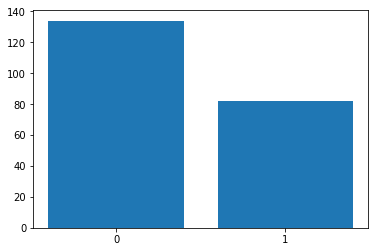

In [44]:
#How many tumors do we have of each type
counts = {k:len(v.columns) for (k,v) in tumorsByRelapse.items()}
plt.bar(counts.keys(), counts.values())
plt.xticks([0,1])

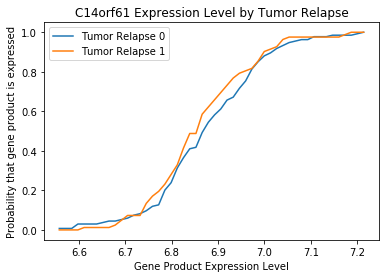

In [46]:
#distrubtion of expression level for a gene segemented by tumor type
geneIdx = 956 #the gene we want to plot by its index
geneIdent = probeIdToGene[rawExpressionData.iloc[geneIdx].name] #its actual name

minVal = rawExpressionData.iloc[geneIdx].min()
maxVal = rawExpressionData.iloc[geneIdx].max()

bins = np.linspace(minVal, maxVal, 50)

for i in range(0,2):
    plt.plot(bins, constructPdfData(tumorsByRelapse[i].iloc[geneIdx], bins, True), label='Tumor Relapse ' + str(i))

plt.title(str(geneIdent) + ' Expression Level by Tumor Relapse')
plt.ylabel('Probability that gene product is expressed')
plt.xlabel('Gene Product Expression Level')
plt.legend()

In [90]:
#test for differences in gene expression by gene by survival
alpha = 0.01
numGenes = len(tumorsByRelapse[0])
genesWhichAreDifferent = []
        
for geneIdx in range(0,numGenes):             
    pvalue = stats.ttest_ind(tumorsByRelapse[0].iloc[geneIdx], tumorsByRelapse[1].iloc[geneIdx], equal_var = False).pvalue
    if pvalue < alpha:
        geneIdent = probeIdToGene[rawExpressionData.iloc[geneIdx].name] #its actual name
        genesWhichAreDifferent.append(geneIdent)

print('Between tumor replapse types there are ', len(genesWhichAreDifferent), ' genes products which are expressed differently')

Between tumor replapse types there are  1433  genes products which are expressed differently


In [91]:
writeGeneListToFile('Diff_Relapse_01.txt', genesWhichAreDifferent)

print('Wrote out all the gene products which are statistically significantly different between relapse types')

Wrote out all the gene products which are statistically significantly different between relapse types


In [92]:
#go through the gene expressions and limit from all gene products to just those which are special
sampleData = []
tumorTypes = []

acceptableGeneSet = set(genesWhichAreDifferent)

for relapse in tumorsByRelapse:
    for tumor in tumorsByRelapse[relapse]:
        expressionLevels = []
        for probeId, expressionLevel in tumorsByRelapse[relapse][tumor].iteritems():
            if probeIdToGene[probeId] in acceptableGeneSet:
                expressionLevels.append(expressionLevel)

        tumorTypes.append(relapse)
        sampleData.append(expressionLevels)
            
print('Sample Data Len ', len(sampleData))
print('Feature Set Size ', len(sampleData[0]))

Sample Data Len  216
Feature Set Size  1694


In [93]:
from sklearn import model_selection

from sklearn.cluster import FeatureAgglomeration

print('Starting Sample Size ', len(sampleData))
print('Starting Feature Size ', len(sampleData[0]))

#cluster the special genes into 6 clusters
agglo = FeatureAgglomeration(n_clusters=6)
agglo.fit(sampleData)
sampleDataReducedF = agglo.transform(sampleData)

print()
print('Agglo Params')
print(agglo.get_params())
print()

#build data set for testing and training
validationSize = 0.20
seed = 9
X_train, X_test, y_train, y_test = model_selection.train_test_split(sampleDataReducedF, 
                                                                    tumorTypes, 
                                                                    test_size=validationSize, 
                                                                    random_state=seed)
print('Built Data Set...')
print('Sample Size ', len(sampleDataReducedF))
print('Feature Size ', len(sampleDataReducedF[0]))
print('Training Size ', len(X_train))
print('Testing Size ', len(y_train))

#now we try to classify the unclassified tumors 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPClassifier
#this is to rescale the data before classification if necessary
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()  
# Don't cheat - fit only on training data

#scaler.fit(X_train)  
#X_train = scaler.transform(X_train)  

# apply same transformation to test data
#X_test = scaler.transform(X_test)
#clf = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=(1024, 256), random_state=1)

#import sklearn.naive_bayes as naive_bayes
#import sklearn.ensemble as ensemble #RandomForestClassifier

clf = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', random_state=seed)
#clf = naive_bayes.GaussianNB()

params = clf.get_params()
print('All paramters used to generate the model')
print(params)
print('')

print('Training...')
clf.fit(X_train, y_train)

yHat = clf.predict(X_test)

print('Confusion Matrix')
print(confusion_matrix(y_test, yHat))

acc = clf.score(X_test, y_test)
print('Score for the classifier', acc)

mse = mean_squared_error(y_test, yHat)
print('Mean Square Error ', mse)

feature_importances = clf.feature_importances_
print('How important are each of our cluters to the model')
print(feature_importances)

Starting Sample Size  216
Starting Feature Size  1694

Agglo Params
{'affinity': 'euclidean', 'compute_full_tree': 'auto', 'connectivity': None, 'linkage': 'ward', 'memory': None, 'n_clusters': 6, 'pooling_func': <function mean at 0x11a899598>}

Built Data Set...
Sample Size  216
Feature Size  6
Training Size  172
Testing Size  172
All paramters used to generate the model
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 9, 'verbose': 0, 'warm_start': False}

Training...
Confusion Matrix
[[27  5]
 [ 4  8]]
Score for the classifier 0.7954545454545454
Mean Square Error  0.20454545454545456
How important are each of our cluters to the model
[0.20817518 0.17189731 0.15812545 0.10616346 0.18040609 0.17523